# Preproc

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_csv('../../raw_data/2011_2021_caluire_phys_v0.csv')
df = df[['DatePrel', '1340']]
df['DatePrel'] = pd.to_datetime(df['DatePrel'])
df['month'] = df['DatePrel'].dt.month
df['year'] = df['DatePrel'].dt.year
df.groupby(['year', 'month'], as_index = False).mean()
df['date'] = pd.to_datetime(dict(year = df.year, month = df.month, day = 1), format = '%Y%m')
df = df.drop(columns = ['DatePrel', 'month', 'year'])
df = df.set_index('date')
df = df.rename(columns = {'1340' : 'nitrates'})
df = df.groupby(['date']).mean()
#df.head(12)

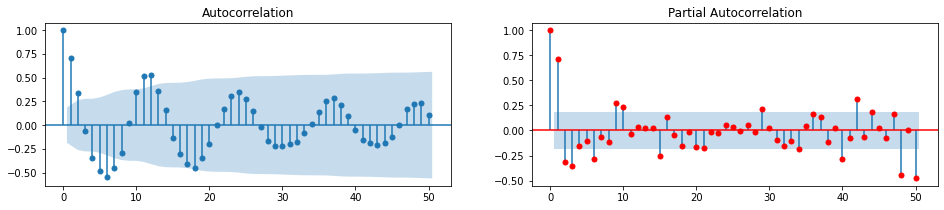

In [4]:
# ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df.nitrates, lags=50, ax=axes[0]);
plot_pacf(df.nitrates, lags=50, ax=axes[1], color='r');

In [5]:
result_mul = seasonal_decompose(df['nitrates'], model = 'multiplicative', period = 12)

In [6]:
def differentials(df):
    zero_diff = df.nitrates
    first_order_diff = df.nitrates.diff(1)
    second_order_diff = df.nitrates.diff(1).diff(1)
    return zero_diff, first_order_diff, second_order_diff
    
def plot_differentials(df):
    
    diffs = differentials(df)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    ax1.plot(diffs[0]); ax1.set_title('Original Series')
    ax2.plot(diffs[1]); ax2.set_title('1st Order Differencing')
    ax3.plot(diffs[2]); ax3.set_title('2nd Order Differencing');
    
def deseasonalized(df):
    df['deseasonalized'] = df.nitrates.values/result_mul.seasonal
    df['linearized'] = np.log(df['deseasonalized'])
    return df['deseasonalized'], df['linearized']

def plot_deseasonalized(df):
    deseason = deseasonalized(df)
    plt.figure(figsize=(15,4));
    plt.subplot(1,2,1); plt.plot(deseason[0]);
    plt.title('Deseasonalized', fontsize=16);
    plt.subplot(1,2,2); plt.plot(deseason[1])
    plt.title('Deseasonalized and Linearized', fontsize=16);

In [7]:
train = deseasonalized(df)[1][:89]
test = deseasonalized(df)[1][89:]

# Model

In [8]:
smodel = pm.auto_arima(train,
                       start_p=1, max_p=3,
                       start_q=1, max_q=3,
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=17.431, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=395.286, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=286.476, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19.426, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19.411, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=207.537, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=17.703, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=20.881, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=0.694, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20.623, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5.410, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3.981, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-0.351, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1.282, Time=0.11 sec
 

In [22]:
arima = ARIMA(train, order=(2,1,2)).fit()
arima.summary()
forecast, std_err, confidence_int = arima.forecast(len(test), alpha=0.05)

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.35044D-02    |proj g|=  2.63144D-01

At iterate    5    f= -4.91719D-02    |proj g|=  1.21045D-02

At iterate   10    f= -7.59206D-02    |proj g|=  2.68493D-01

At iterate   15    f= -8.41477D-02    |proj g|=  1.00970D-02

At iterate   20    f= -8.44831D-02    |proj g|=  6.14803D-01

At iterate   25    f= -8.80252D-02    |proj g|=  1.09450D-02

At iterate   30    f= -8.80257D-02    |proj g|=  2.47937D-03

At iterate   35    f= -8.80281D-02    |proj g|=  2.30519D-02

At iterate   40    f= -8.80295D-02    |proj g|=  6.52801D-03

At iterate   45    f= -8.80297D-02    |proj g|=  7.64060D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [19]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

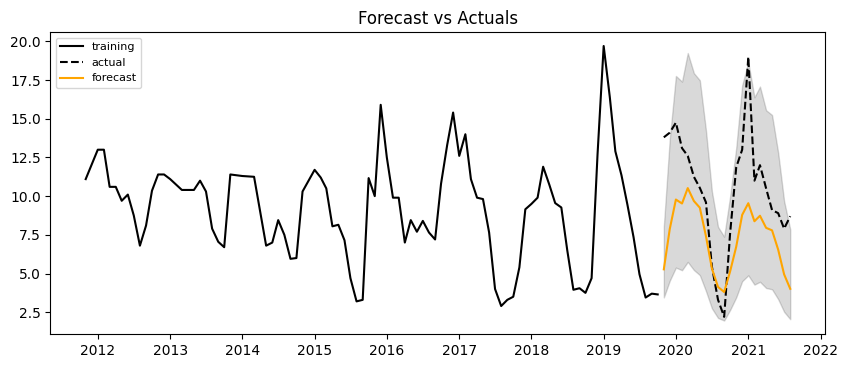

In [20]:
forecast_recons = np.exp(forecast)*result_mul.seasonal[89:]
train_recons = np.exp(train)*result_mul.seasonal[:89]
test_recons = np.exp(test)*result_mul.seasonal[89:]
lower_recons = np.exp(confidence_int)[:,0]*result_mul.seasonal[89:]
upper_recons = np.exp(confidence_int)[:,1]*result_mul.seasonal[89:]

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)